In [1]:
import tensorflow as tf
import cv2
import numpy as np
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [2]:
def imgpath_list_to_array_list(imgpath_list,imgsize=(256,256)):
    array_list = []
    for img_path in imgpath_list:
        img = cv2.imread(img_path,0)
        img = cv2.resize(img,imgsize)
        #img = img[:,:,0]
        #img = (img-127.5)/127.5
        array_list.append(img.reshape(imgsize[0],imgsize[1]))
    return np.array(array_list)
imgsize = (128,128)

In [3]:
#prepare training data
import pandas as pd
train_csv_path = '/root/notebooks/0858611-2/tooth_xray/model/700_400_Flip_No_Crop/dataset/train_label.csv'
train_tooth_dataframe = pd.read_csv (train_csv_path)
#tooth_dataframe = tooth_dataframe.sort_values(by=['Image_path'][-35:])
print (train_tooth_dataframe.head())

train_img_path_list = train_tooth_dataframe.Image_path
train_img_label_list = train_tooth_dataframe.label



                                          Image_path  label
0  /root/notebooks/0858611-2/tooth_xray/model/700...      2
1  /root/notebooks/0858611-2/tooth_xray/model/700...      1
2  /root/notebooks/0858611-2/tooth_xray/model/700...      2
3  /root/notebooks/0858611-2/tooth_xray/model/700...      2
4  /root/notebooks/0858611-2/tooth_xray/model/700...      1


In [4]:
#prepare test data
import pandas as pd
test_csv_path = '/root/notebooks/0858611-2/tooth_xray/model/700_400_Flip_No_Crop/dataset/test_label.csv'
test_tooth_dataframe = pd.read_csv (test_csv_path)
#tooth_dataframe = tooth_dataframe.sort_values(by=['Image_path'][-35:])
print (test_tooth_dataframe.head())
test_img_path_list = test_tooth_dataframe.Image_path
test_img_label_list = test_tooth_dataframe.label

test_data_array = imgpath_list_to_array_list(test_tooth_dataframe.Image_path,imgsize)
test_label_array = np.array(test_tooth_dataframe.label)

test_data_array = test_data_array[..., tf.newaxis].astype('float32')
test_label_array = tf.keras.utils.to_categorical(test_label_array, num_classes=3)

                                          Image_path  label
0  /root/notebooks/0858611-2/tooth_xray/model/700...      0
1  /root/notebooks/0858611-2/tooth_xray/model/700...      0
2  /root/notebooks/0858611-2/tooth_xray/model/700...      0
3  /root/notebooks/0858611-2/tooth_xray/model/700...      1
4  /root/notebooks/0858611-2/tooth_xray/model/700...      0


In [5]:
normal_dataframe = train_tooth_dataframe[train_tooth_dataframe.label == 0]
medium_dataframe = train_tooth_dataframe[train_tooth_dataframe.label == 1]
serious_dataframe = train_tooth_dataframe[train_tooth_dataframe.label == 2]
print(len(normal_dataframe))
print(len(medium_dataframe))
print(len(serious_dataframe))

from sklearn.utils import shuffle
normal_dataframe = shuffle(normal_dataframe)
medium_dataframe = shuffle(medium_dataframe)
serious_dataframe = shuffle(serious_dataframe)

12662
7478
3860


In [6]:
min_len = min(len(normal_dataframe),len(medium_dataframe),len(serious_dataframe))
print(min_len)

3860


In [7]:
from sklearn.utils import shuffle

train_tooth_dataframe = pd.concat([normal_dataframe[:min_len],medium_dataframe[:min_len],serious_dataframe[:min_len]],axis=0)
print(len(train_tooth_dataframe))
train_tooth_dataframe = shuffle(train_tooth_dataframe)
print(train_tooth_dataframe.head())

11580
                                              Image_path  label
2631   /root/notebooks/0858611-2/tooth_xray/model/700...      1
21072  /root/notebooks/0858611-2/tooth_xray/model/700...      1
10986  /root/notebooks/0858611-2/tooth_xray/model/700...      1
21055  /root/notebooks/0858611-2/tooth_xray/model/700...      1
337    /root/notebooks/0858611-2/tooth_xray/model/700...      0


In [8]:
normal_data_array = imgpath_list_to_array_list(normal_dataframe[:min_len].Image_path,imgsize)
normal_label_array = np.array(normal_dataframe[:min_len].label)
normal_data_array = normal_data_array[..., tf.newaxis].astype('float32')
normal_label_array = tf.keras.utils.to_categorical(normal_label_array, num_classes=3)


medium_data_array = imgpath_list_to_array_list(medium_dataframe[:min_len].Image_path,imgsize)
medium_label_array = np.array(medium_dataframe[:min_len].label)
medium_data_array = medium_data_array[..., tf.newaxis].astype('float32')
medium_label_array = tf.keras.utils.to_categorical(medium_label_array, num_classes=3,)


serious_data_array = imgpath_list_to_array_list(serious_dataframe[:min_len].Image_path,imgsize)
serious_label_array = np.array(serious_dataframe[:min_len].label)
serious_data_array = serious_data_array[..., tf.newaxis].astype('float32')
serious_label_array = tf.keras.utils.to_categorical(serious_label_array, num_classes=3)

In [9]:
#img to array and resize 
import cv2
import numpy as np
import matplotlib.pyplot as plt



train_data_array = imgpath_list_to_array_list(train_tooth_dataframe.Image_path,imgsize)
train_label_array = np.array(train_tooth_dataframe.label)

train_data_array = train_data_array[..., tf.newaxis].astype('float32')
train_label_array = tf.keras.utils.to_categorical(train_label_array, num_classes=3)

# train_data_array = np.concatenate(normal_data_array,medium_data_array,serious_data_array)
# train_label_array = np.concatenate(normal_label_array,medium_label_array,serious_label_array)

In [10]:
print(train_data_array.shape)
print(train_label_array.shape)
print(test_data_array.shape)
print(test_label_array.shape)

(11580, 128, 128, 1)
(11580, 3)
(2000, 128, 128, 1)
(2000, 3)


In [11]:
from tensorflow.keras import Model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input,Dropout


def my_vgg_model(input_shape, classes):
    inputs=Input(input_shape)
    x = Conv2D(512, (3, 3),padding = 'same', activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3),padding = 'same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3),padding = 'same', activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3),padding = 'same', activation='relu',name = 'target_layer')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(classes)(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape= (128,128,1)
classes    = 3
batch_size = 128
epochs     = 30

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
with mirrored_strategy.scope():
    vgg_model = my_vgg_model(input_shape, classes)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [12]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 512)     5120      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       1179904   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0     

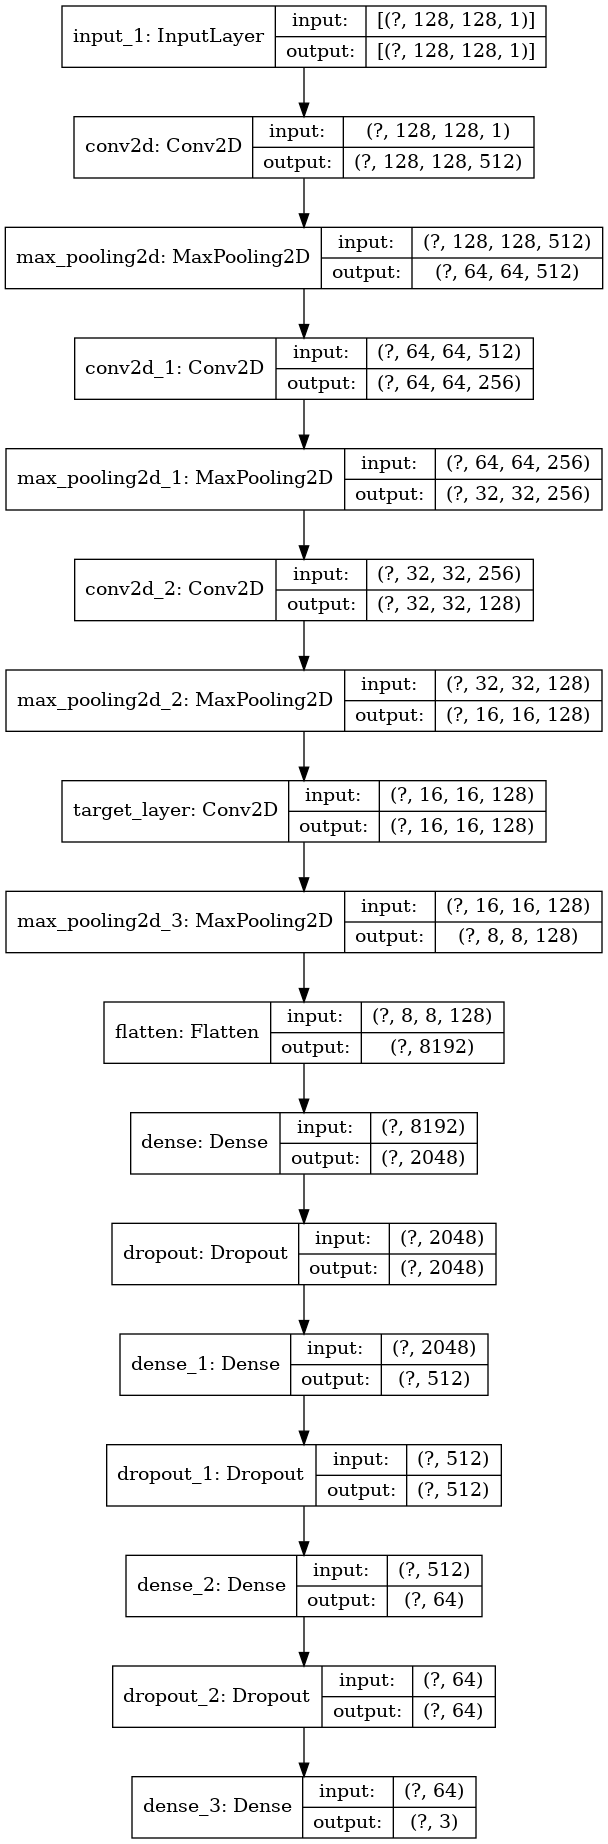

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(vgg_model,show_shapes = True  )###

In [14]:
data_to_train_rate = 0.9
data_to_validation_rate = 0.1
train_unms = int(len(train_label_array)*data_to_train_rate)
print('Have {} data, {} for training , {} for validation'
      .format(len(train_label_array),train_unms,len(train_label_array)-train_unms))

Have 11580 data, 10422 for training , 1158 for validation


In [15]:
history = vgg_model.fit(train_data_array[:train_unms], train_label_array[:train_unms], 
                                 validation_data=(train_data_array[train_unms:], train_label_array[train_unms:]),epochs=epochs,shuffle=True,batch_size = batch_size)

Train on 10422 samples, validate on 1158 samples
Epoch 1/30
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 16 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then 

In [16]:
modelpredict = my_vgg_model(input_shape, classes)

weights = vgg_model.get_weights()
modelpredict.set_weights(weights)

1158/1 - 1s - loss: 1.0780 - accuracy: 0.3964


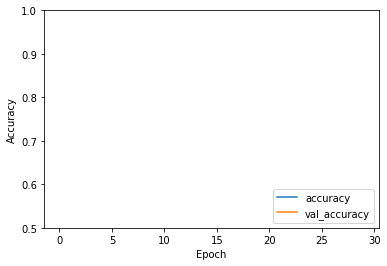

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = vgg_model.evaluate(train_data_array[train_unms:],  train_label_array[train_unms:], verbose=2)

In [18]:
vgg_model.evaluate(train_data_array[train_unms:],  train_label_array[train_unms:], verbose=2)

1158/1 - 2s - loss: 1.0780 - accuracy: 0.3964


[1.0703792876736076, 0.39637306]

In [19]:
print('following is recall rate')
print('\n# Evaluate on normal_data')
vgg_model.evaluate(normal_data_array,normal_label_array, verbose=2)

print('\n# Evaluate on medium_data')
vgg_model.evaluate(medium_data_array,medium_label_array, verbose=2)

print('\n# Evaluate on serious_data')
vgg_model.evaluate(serious_data_array,serious_label_array, verbose=2)

following is recall rate

# Evaluate on normal_data
3860/1 - 2s - loss: 1.0721 - accuracy: 0.4961

# Evaluate on medium_data
3860/1 - 2s - loss: 1.0878 - accuracy: 0.1469

# Evaluate on serious_data
3860/1 - 2s - loss: 1.0399 - accuracy: 0.6210


[1.0153754982923597, 0.62098444]

In [20]:
#prediction 

In [21]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def recall_accuracy_rate(test_data_array,test_label_array,model):
    model_predict =[]
    for img in test_data_array:
        reshape = np.expand_dims(img, axis=0)
        image = tf.cast(reshape, tf.float32)
        model_predict.append(np.argmax(model.predict(image)))
    test_label_array = np.argmax(test_label_array,axis=1)
    matrix = confusion_matrix(test_label_array, model_predict)
    matrix_split = np.split(matrix,3,axis=1)
    print('column:* is prediction result')
    print('row*: is real class')
    dict = {#"": img_path,
            "class:0":matrix_split[0].reshape(3),
            "class:1":matrix_split[1].reshape(3),
            "class:2":matrix_split[2].reshape(3)
           }
    
    predict_table = pd.DataFrame(dict)
    return predict_table,matrix

In [22]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

In [23]:
# test_data_array8 = test_data_array[:8]
# test_label_array8 = test_label_array[:8]
# print(test_label_array8)
# model_predictt = []
# model = modelpredict
# for img in test_data_array8:
#     reshape = np.expand_dims(img, axis=0)
#     image = tf.cast(reshape, tf.float32)
#     model_predictt.append(np.argmax(model.predict(image)))
# test_label_array8 = np.argmax(test_label_array8,axis=1)
# confusion_matrix(test_label_array8, model_predictt)

In [24]:
predict_table,matrix = recall_accuracy_rate(test_data_array,test_label_array,modelpredict)
for i in range(len(predict_table.columns)):
    p = precision(i,matrix)
    r = recall(i,matrix) 
    print('The {} precision is {:.4f}% in {} prediction and recall is {:.4f}% in {} sample'
          .format(predict_table.columns[i],p*100,matrix[:,i].sum(),r*100,matrix[i, :].sum()))
    print()

column:* is prediction result
row*: is real class
The class:0 precision is 74.4898% in 1078 prediction and recall is 58.4425% in 1374 sample

The class:1 precision is 38.8268% in 358 prediction and recall is 24.2583% in 573 sample

The class:2 precision is 9.3972% in 564 prediction and recall is 100.0000% in 53 sample



In [25]:
predict_table.head()

,class:0,class:1,class:2
0,803,219,352
1,275,139,159
2,0,0,53


In [26]:

%load_ext tensorboard
file_writer = tf.summary.create_file_writer('/root/notebooks/0858611-2/tf-explain/logs')
%tensorboard --logdir '/root/notebooks/0858611-2/tf-explain/logs'


Reusing TensorBoard on port 6008 (pid 38045), started 7 days, 2:24:48 ago. (Use '!kill 38045' to kill it.)

In [27]:
test_images = test_data_array
test_labels = test_label_array

In [28]:
validation_class_zero = (np.array([
    el for el, label in zip(test_images, test_labels)
    if np.all(np.argmax(label) == 0)
][0:9]), None)

In [29]:
validation_class_fours = (np.array([
    el for el, label in zip(test_images, test_labels)
    if np.all(np.argmax(label) == 2)
][0:9]), None)

In [30]:
import tf_explain
callbacks = [
    tf_explain.callbacks.GradCAMCallback(validation_class_zero, layer_name='target_layer', class_index=0),
    tf_explain.callbacks.GradCAMCallback(validation_class_fours, layer_name='target_layer', class_index=2),
    tf_explain.callbacks.ActivationsVisualizationCallback(validation_class_zero, layers_name=['target_layer']),
    tf_explain.callbacks.SmoothGradCallback(validation_class_zero, class_index=0, num_samples=15, noise=1.),
    tf_explain.callbacks.IntegratedGradientsCallback(validation_class_zero, class_index=0, n_steps=10),
    tf_explain.callbacks.VanillaGradientsCallback(validation_class_zero, class_index=0),
]

In [31]:
modelpredict.fit(test_images,test_labels, epochs=5,batch_size = batch_size,callbacks=callbacks)

Train on 2000 samples
Epoch 1/5
1920/2000 [===========================>..] - ETA: 0s - loss: 4.7441 - accuracy: 0.4516WARNING:tensorflow:From /opt/conda/lib/python3.6/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
2000/2000 [==============================] - 17s 8ms/sample - loss: 4.6249 - accuracy: 0.4420
Epoch 2/5
2000/2000 [==============================] - 4s 2ms/sample - loss: 0.9956 - accuracy: 0.1075
Epoch 3/5
2000/2000 [==============================] - 5s 2ms/sample - loss: 0.8510 - accuracy: 0.0265
Epoch 4/5
2000/2000 [==============================] - 5s 2ms/sample - loss: 1.3796 - accuracy: 0.0265
Epoch 5/5
2000/2000 [==============================] - 5s 2ms/sample - loss: 5.4908 - accuracy: 0.1460


In [32]:
# rm -r ./logs/*

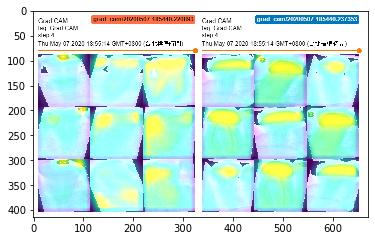

In [34]:
#heatmpa result 
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/root/notebooks/0858611-2/tooth_xray/model/heatmap_result/tooth_model_convolution_VGG_base.PNG')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)